In [0]:
import keras
from keras_preprocessing import text
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding, Input, Conv1D, MaxPooling1D, LSTM, Dropout
from keras import backend as K
import keras.initializers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import zipfile
import csv,io
import nltk
import string
from string import punctuation
import re
import zipfile
from sklearn.preprocessing import LabelBinarizer

In [0]:
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Constants

EMBED_SIZE=300
VOCAB_SIZE = 10000
INDEX_FROM = 2
#MAXIMUM_LENGTH = 500
TRAIN_SPLIT = 0.3

In [0]:
# Get Data
!wget http://alt.qcri.org/semeval2017/task4/data/uploads/codalab/4a-arabic.zip

--2019-02-20 18:16:23--  http://alt.qcri.org/semeval2017/task4/data/uploads/codalab/4a-arabic.zip
Resolving alt.qcri.org (alt.qcri.org)... 13.93.27.76
Connecting to alt.qcri.org (alt.qcri.org)|13.93.27.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68035 (66K) [application/zip]
Saving to: ‘4a-arabic.zip’

4a-arabic.zip       100%[===================>]  66.44K   215KB/s    in 0.3s    

2019-02-20 18:16:23 (215 KB/s) - ‘4a-arabic.zip’ saved [68035/68035]



In [0]:
os.listdir()

['.config',
 'SemEval2017-task4-dev.subtask-A.english.INPUT.txt',
 '4a-arabic.zip',
 'glove.6B.300d.txt',
 'glove.6B.50d.txt',
 'glove.6B.zip',
 '4a-english.zip',
 'SemEval2017-task4-test.subtask-A.english.txt',
 'SemEval2017-task4-test.subtask-CE.arabic.txt',
 'Task4_Eng_lstm4.h5',
 'glove.6B.200d.txt',
 'glove.6B.100d.txt',
 'sample_data']

In [0]:
# Extract Training Data File

def extract_without_folder(arc_name, full_item_name, folder):
    with zipfile.ZipFile(arc_name) as zf:
        file_data = zf.read(full_item_name)
    with open(os.path.join(folder, os.path.basename(full_item_name)), "wb") as fout:
        fout.write(file_data)

path_to_zip_file = '4a-arabic.zip'
directory_to_extract_to = os.getcwd()  
extract_without_folder(path_to_zip_file,'4A-Arabic/SemEval2017-task4-dev.subtask-A.arabic.INPUT.txt',directory_to_extract_to )

In [0]:
#Sanity Check: Read and Display data
text_file = open("SemEval2017-task4-dev.subtask-A.arabic.INPUT.txt", "r")
corpus = text_file.read()
print(len(corpus))
print(corpus[:1000])

85003
781400143144726529	positive	"إطلالة أنيقة وانثوية من مجموعة غوتشي لخريف/شتاء 2016 https://t.co/2MG7282hjh https://t.co/9p5a6bIAk7"
781476002463711232	neutral	"أخر صيحة من حقائب اليد من فندي وغوتشي https://t.co/x6lG3LrC37#فندي #غوتشي #بنات_الخبر"
781485165000396800	positive	"تتشرف #باري_غاليري بدعوتكم لحضور ومقابلة #نجوى_محمد #خبيرة_التجميل عند نقطة بيع مستحضرات تجميل #غوتشي يوم 30 سبتمبر… https://t.co/BZR1cRfaa1"
781542717218254848	neutral	"RT @ArabRapMonster: [ستايل]بنطال #نامجون الجينز لصور #WINGS كان بسعر 815 جنيه استرليني من ماركة غوتشي-GUCCIما يعادل3980 ريال سعودي https:…"
781730607919460352	neutral	"RT @wufan_styleee: 160930 كريس في The Amazing Idolازياء كريس جميعها من بربري من المجموعه الاخيره،حذاءه من اديداس اوريجنال ونظارته من غوتشي…"
781795913975140352	neutral	"تعرفي على حذاء #غوتشي الذي يجمع بين الكعب العالي والمسطحعبر الرابط https://t.co/i9W8OUykn9 https://t.co/TtUPpnAbkc"
781828427984797696	positive	"غوتشي فلورا الأسود فخم  💕💕💕💕 https://t.co/PPbGl9BVgF"
7818798365288

In [0]:
#Preprocessing 1 - Create tweet data and labels

labels = []
tweets = []
f = csv.reader(io.StringIO(corpus), delimiter='\t')
for row in f:
  labels.append(row[1])
  tweets.append(row[2])
    #print(row[1], row[2])

In [0]:
remove_terms = punctuation + '0123456789'

In [0]:
def normalize_document(doc):
    stop_words = nltk.corpus.stopwords.words('english')
    wpt = nltk.WordPunctTokenizer()


    # lower case and remove special characters\whitespaces

    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)

    doc = doc.lower()

    doc = doc.strip()

    # tokenize document

    tokens = wpt.tokenize(doc)

    # filter stopwords out of document

    filtered_tokens = [token for token in tokens if token not in stop_words]

    # re-create document from filtered tokens

    doc = ' '.join(filtered_tokens)

    return doc

In [0]:
normalize_corpus = np.vectorize(normalize_document)
normalized_corpus = [[word.lower() for word in sent if word not in remove_terms] for sent in tweets]

normalized_corpus = [''.join(tok_sent) for tok_sent in normalized_corpus]

#normalized_corpus = filter(None, normalize_corpus(normalized_corpus))
#normalized_corpus = list(normalized_corpus)
#normalized_corpus = [tok_sent for tok_sent in normalized_corpus if len(tok_sent.split()) > 2]

normalized_corpus = list(normalized_corpus)

In [0]:
print(len(tweets))
print(len(normalized_corpus))
print(tweets[0])
print(normalized_corpus[0])

671
671
إطلالة أنيقة وانثوية من مجموعة غوتشي لخريف/شتاء 2016 https://t.co/2MG7282hjh https://t.co/9p5a6bIAk7
إطلالة أنيقة وانثوية من مجموعة غوتشي لخريفشتاء  httpstcomghjh httpstcopabiak


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=VOCAB_SIZE)
tokenizer.fit_on_texts(normalized_corpus)
sequences = tokenizer.texts_to_sequences(normalized_corpus)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5177 unique tokens.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [0]:
def lengths(x):
    if isinstance(x,list):
        yield len(x)
        for y in x:
            yield from lengths(y)

MAXIMUM_LENGTH = max([len(x) for x in normalized_corpus])

In [0]:
from keras.utils import to_categorical

data = pad_sequences(sequences, maxlen=MAXIMUM_LENGTH)

#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)

Shape of data tensor: (671, 140)


In [0]:
print(data[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0 939 940 941   3 431  14 942 943 944]


In [0]:
os.listdir()

['.config',
 'SemEval2017-task4-dev.subtask-A.arabic.INPUT.txt',
 'full_grams_sg_100_twitter.zip',
 '4a-arabic.zip.1',
 'full_grams_sg_100_twitter.mdl.wv.vectors.npy',
 'full_grams_sg_100_twitter.mdl',
 'full_grams_sg_100_twitter.mdl.trainables.syn1neg.npy',
 '4a-arabic.zip',
 'sample_data']

In [0]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
data = data[indices]
#labels = labels[indices]


In [0]:


nb_validation_samples = int(TRAIN_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]




In [0]:
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)

In [0]:
# Get Pre-trained Embeddings - Fasttetxt

!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz

--2019-02-20 18:17:20--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G  54.2MB/s    in 21s     

2019-02-20 18:17:42 (57.4 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [0]:
!pip install patool



    100% |████████████████████████████████| 81kB 5.0MB/s 


In [0]:
import patoolib

path_to_zip_file = 'cc.ar.300.vec.gz'
directory_to_extract_to = os.getcwd()  
patoolib.extract_archive(path_to_zip_file,outdir = directory_to_extract_to )

patool: Extracting cc.ar.300.vec.gz ...
patool: running /usr/bin/7z e -o/content -- cc.ar.300.vec.gz
patool: ... cc.ar.300.vec.gz extracted to `/content'.


'/content'

In [0]:

os.listdir()

['.config',
 'cc.ar.300.vec.gz',
 'SemEval2017-task4-dev.subtask-A.arabic.INPUT.txt',
 'full_grams_sg_100_twitter.zip',
 '4a-arabic.zip.1',
 'full_grams_sg_100_twitter.mdl.wv.vectors.npy',
 'full_grams_sg_100_twitter.mdl',
 'cc.ar.300.vec',
 'full_grams_sg_100_twitter.mdl.trainables.syn1neg.npy',
 '4a-arabic.zip',
 'sample_data']

In [0]:
embeddings_index = {}
f = open('cc.ar.300.vec')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 2000000 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAXIMUM_LENGTH,
                            trainable=False)

In [0]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [0]:
# Model with Embedding Layer
model = Sequential()

#We change our first layer in model1 to an Embedding layer
model.add(keras.layers.Embedding(VOCAB_SIZE,16))


#The second layer is to compute average on all word vectors 
model.add(GlobalAveragePooling1DMasked())



#The output vector is piped through a fully-connected layer
model.add(keras.layers.Dense(16, activation=K.relu))



#The last layer is connected with a single output node with the sigmoid activation function
model.add(keras.layers.Dense(3, activation=K.softmax))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_mas (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total params: 160,323
Trainable params: 160,323
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train,
                    np.array(y_train),
                    epochs=3,
                    batch_size=100,
                    validation_data=(x_val, np.array(y_val)),
                    verbose=1)


Train on 470 samples, validate on 201 samples
Epoch 1/3
470/470 [==============================] - 0s 978us/step - loss: 1.0869 - acc: 0.3957 - val_loss: 1.0979 - val_acc: 0.1741
Epoch 2/3
470/470 [==============================] - 0s 86us/step - loss: 1.0796 - acc: 0.3979 - val_loss: 1.0989 - val_acc: 0.1741
Epoch 3/3
470/470 [==============================] - 0s 73us/step - loss: 1.0717 - acc: 0.3979 - val_loss: 1.0996 - val_acc: 0.1741


In [0]:
#print(x_train[0])
#print(y_train[0])
print(x_val[0])
print(y_val[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 17 37 30 35 20 22 39 17 37 30  1 16  8  9
 14  2 29  4 29  3  6 13  7  2 28 16  4  9  2  4 15  8 24 12  1  3 28  5
 23 45 46]
[0 1 0]


In [0]:
model_lstm = Sequential() 

model_lstm.add(embedding_layer)

#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm.add(LSTM(100)) 
model_lstm.add(Dense(3, activation='softmax')) 
model_lstm.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          1553400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 1,714,103
Trainable params: 160,703
Non-trainable params: 1,553,400
_________________________________________________________________


In [0]:
history = model_lstm.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 470 samples, validate on 201 samples
Epoch 1/6
470/470 [==============================] - 4s 8ms/step - loss: 1.0832 - acc: 0.4255 - val_loss: 1.0955 - val_acc: 0.4677
Epoch 2/6
470/470 [==============================] - 3s 7ms/step - loss: 1.0278 - acc: 0.5128 - val_loss: 1.1239 - val_acc: 0.5075
Epoch 3/6
470/470 [==============================] - 3s 7ms/step - loss: 0.9946 - acc: 0.5298 - val_loss: 1.1912 - val_acc: 0.5075
Epoch 4/6
470/470 [==============================] - 3s 6ms/step - loss: 0.9735 - acc: 0.5574 - val_loss: 1.1321 - val_acc: 0.4826
Epoch 5/6
470/470 [==============================] - 3s 6ms/step - loss: 0.9453 - acc: 0.5809 - val_loss: 1.0976 - val_acc: 0.4826
Epoch 6/6
470/470 [==============================] - 3s 6ms/step - loss: 0.9104 - acc: 0.5830 - val_loss: 1.3420 - val_acc: 0.1940


In [0]:
results_lstm = model_lstm.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm[0], 'Test Accuracy: ',results_lstm[1])

201/201 [==============================] - 1s 3ms/step
Test Loss:  0.9832397290130159 Test Accuracy:  0.6467661695990397


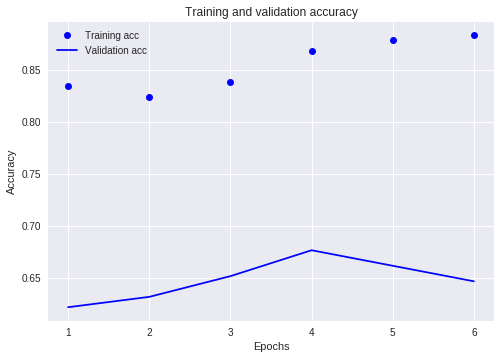

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
model_lstm2 = Sequential() 

model_lstm2.add(embedding_layer)
model_lstm2.add(Dropout(0.1))
#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm2.add(LSTM(100)) 
model_lstm2.add(Dropout(0.1))
model_lstm2.add(Dense(3, activation='softmax')) 
model_lstm2.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model_lstm2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 140, 300)          1553400   
_________________________________________________________________
dropout_15 (Dropout)         (None, 140, 300)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 303       
Total params: 1,714,103
Trainable params: 160,703
Non-trainable params: 1,553,400
_________________________________________________________________


In [0]:
history_lstm2 = model_lstm2.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 470 samples, validate on 201 samples
Epoch 1/6
470/470 [==============================] - 7s 15ms/step - loss: 1.0822 - acc: 0.4319 - val_loss: 1.0780 - val_acc: 0.5274
Epoch 2/6
470/470 [==============================] - 3s 6ms/step - loss: 1.0342 - acc: 0.4574 - val_loss: 1.1022 - val_acc: 0.5274
Epoch 3/6
470/470 [==============================] - 3s 6ms/step - loss: 1.0028 - acc: 0.4596 - val_loss: 1.1479 - val_acc: 0.5274
Epoch 4/6
470/470 [==============================] - 3s 6ms/step - loss: 0.9853 - acc: 0.5170 - val_loss: 1.1638 - val_acc: 0.3532
Epoch 5/6
470/470 [==============================] - 3s 6ms/step - loss: 0.9670 - acc: 0.5745 - val_loss: 1.1177 - val_acc: 0.4478
Epoch 6/6
470/470 [==============================] - 3s 6ms/step - loss: 0.9457 - acc: 0.5979 - val_loss: 1.1114 - val_acc: 0.4577
